## Adapt Mitra method to COSI spectra
- Obtain times, temperatures, and pulse heights from data collected over a wide range of temperatures.
- Bin the data into ~1 C bins and choose the temperature bin with the most events as the "reference temperature."
- Create one spectrum per bin. 
- Identify a function that minimizes the spread of events (RMS) around the reference spectrum's spectral line.

### ADC units, event times, and temperatures from nuclearizer

Using 2016 calibration data: 16/04/23 11:36:11 to 16/04/24 08:56:58

I ran COSI_GCU-042316_113611-042416_085658_Am241_Cs137.fifo.list through nuclearizer -c nuc_roa_allinfo.cfg (only the data loader and save events (to .dat) modules) to make

allinfo_COSI-160423_113611-160424_085658.roa (I truncated it to 3GB because it's enormous otherwise)

UH lines contain the information:
UH DetectorID StripID p/n ADCUnits Timing PreampTemp

I ran that .roa file through code I wrote called write_ADCtimingtemp.py, which parses the "allinfo" roa file into three columns: ADCUnits, Timing, PreampTemp:

ADCtimingtemp_COSI-160423_113611-160424_085658.csv

In [439]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [440]:
ADCtimingtemp_df = pd.read_csv("100M_ADCtimingtemp_COSI-160423_113611-160424_085658.csv")

### Bin the data by temperature
Organize the dataframe into 1 C temperature bins.

In [441]:
temp_bin_width = 1
temp_bins = np.arange(int(ADCtimingtemp_df["PreampTemp"].min()),int(ADCtimingtemp_df["PreampTemp"].max()+temp_bin_width),temp_bin_width)

In [442]:
temp_bin_labels = [str(i) for i in temp_bins]
print(temp_bin_labels)
ADCtimingtemp_df['BinnedTemp'] = pd.cut(ADCtimingtemp_df['PreampTemp'],bins=temp_bins,labels=temp_bin_labels[:-1])
ADCtimingtemp_df

['27', '28', '29', '30', '31', '32', '33', '34']


,ADCunits,Timing,PreampTemp,BinnedTemp
0,571,135.0,32.1685,32
1,125,90.0,32.1685,32
2,693,205.0,31.9214,31
3,1177,160.0,32.1685,32
4,487,260.0,31.9214,31
...,...,...,...,...
6553863,1301,205.0,29.9446,29
6553864,2003,160.0,28.9562,28
6553865,1147,130.0,27.2265,27
6553866,1243,155.0,27.4736,27


### Find the temperature bin with the most events
Group the data by temperature bin and display the number of events in that bin ("count") and the sum of ADC units in that bin ("sum"). Not sure if the latter quantity is useful at all...

In [443]:
temp_groups = ADCtimingtemp_df.groupby(ADCtimingtemp_df["BinnedTemp"])
# Can display the indices for each group corresponding to the rows in the original df that belong to each group
#temp_groups.groups 

In [444]:
binned_df = temp_groups["ADCunits"].agg(["count","sum"])
binned_df

,count,sum
BinnedTemp,,
27,31608,25371291
28,30656,26911668
29,48216,40287711
30,312162,262267306
31,1515003,1269158797
32,1275384,1063290537
33,2237516,1860784830


In [445]:
ref_temp = binned_df.loc[binned_df['count'] == binned_df['count'].max()].index.values[0]
binned_df.loc[binned_df['count'] == binned_df['count'].max()]

,count,sum
BinnedTemp,,
33,2237516,1860784830


The temperature bin with the most events is 33 C. This will contain our "reference spectrum."

### Make one spectrum per temperature bin

In [446]:
# Can view the information in each temperature bin (group) individually
#i=0
#for temp, temp_group in temp_groups:
    #temp = temp_bin_labels[i]
    #print(temp)
    #print(temp_group)
    #i += 1

Text(0.5, 1.0, 'Cs-137+Am-241 Spectrum: Temperatures 33-34$^\\circ$C')

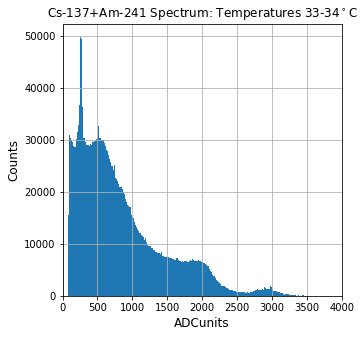

In [447]:
# Can make a spectrum for each temperature bin invidivually
plt.rcParams['figure.figsize'] = [5,5]
temp = int(ref_temp)
temp_group = temp_groups.get_group("{}".format(temp))
hist = temp_group["ADCunits"].hist(bins=500)
hist.set_xlim(0,4000)
#hist.set_ylim(0,100000)
hist.set_xlabel("ADCunits",size=12);hist.set_ylabel("Counts",size=12)
hist.set_title("Cs-137+Am-241 Spectrum: Temperatures {}-{}$^\circ$C".format(temp,temp+temp_bin_width),size=12)

#### BUG: I think the below code skips the last temperature bin? Revisit this...

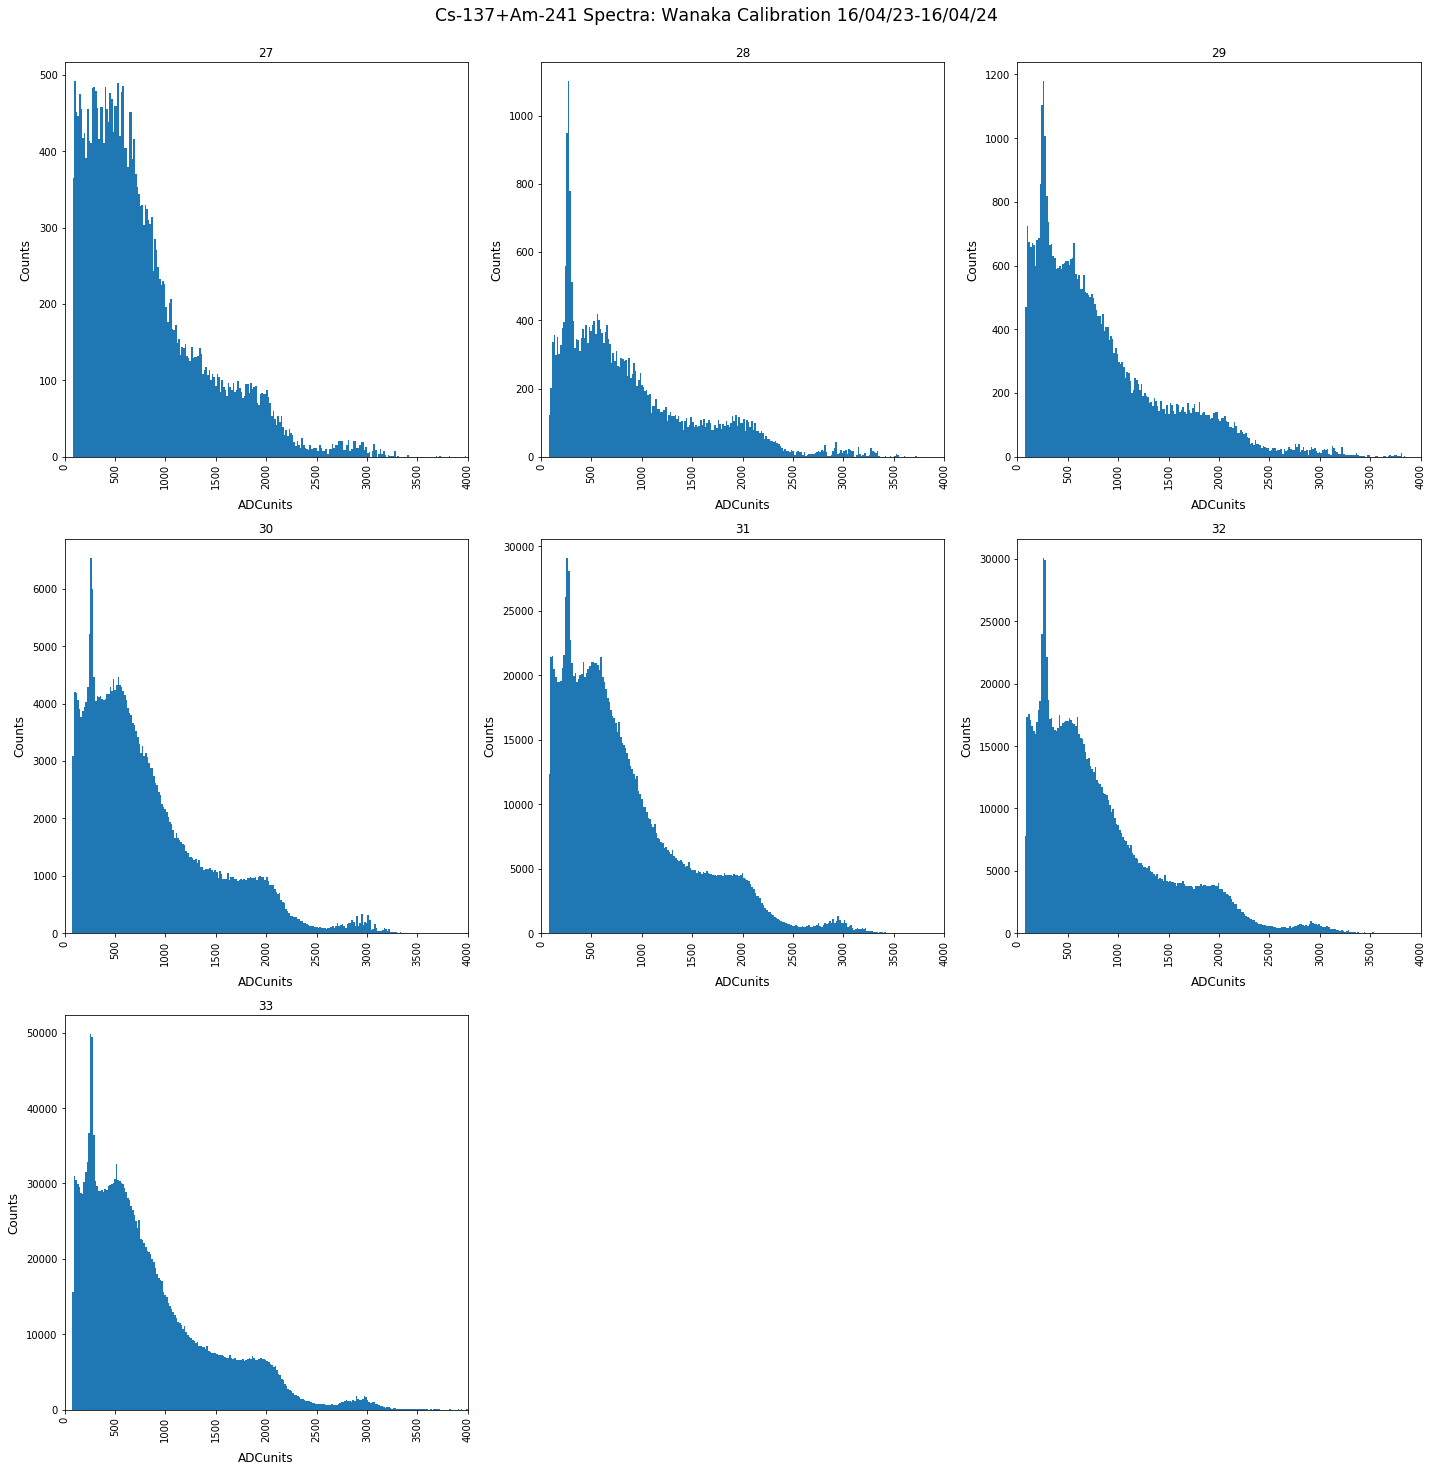

In [448]:
# Or, make a spectrum for all bins at once
plt.rcParams['figure.figsize'] = [20,20]
ax = ADCtimingtemp_df['ADCunits'].hist(by=ADCtimingtemp_df['BinnedTemp'],bins=500)
for i,x in enumerate(ax.flatten()):
    x.set_xlabel("ADCunits",labelpad=10,size=12);x.set_ylabel("Counts",labelpad=6,size=12)  
    #x.set_title("Temperatures {}-{}$^\circ$C".format(int(temp_bin_labels[i]),int(temp_bin_labels[i])+temp_bin_width),size=15)
    x.set_xlim(0,4000)
    
plt.suptitle('Cs-137+Am-241 Spectra: Wanaka Calibration 16/04/23-16/04/24', x=0.5, y=1.02, ha='center', fontsize='xx-large')
plt.tight_layout()

Text(0.5, 1.0, 'Cs-137+Am-241 Spectra')

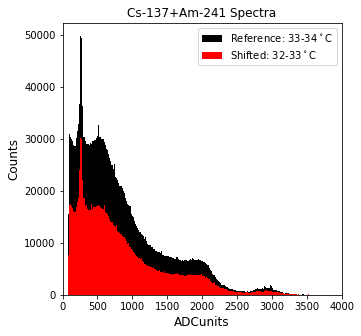

In [449]:
# Overplot a chosen shifted spectrum on the reference spectrum
plt.rcParams['figure.figsize'] = [5,5]

ref_group = temp_groups.get_group("{}".format(ref_temp))
ref_ADC = ref_group["ADCunits"].values

shifted_temp = 32
shifted_group = temp_groups.get_group("{}".format(shifted_temp))
shifted_ADC = shifted_group["ADCunits"].values

plt.hist(ref_ADC,color='k',bins=500,label="Reference: {}-{}$^\circ$C".format(int(ref_temp),int(ref_temp)+temp_bin_width))
plt.hist(shifted_ADC,color='r',bins=500,label="Shifted: {}-{}$^\circ$C".format(int(shifted_temp),int(shifted_temp)+temp_bin_width))
plt.legend(loc='upper right')
plt.xlim(0,4000)
plt.xlabel("ADCunits",size=12);plt.ylabel("Counts",size=12)
plt.title("Cs-137+Am-241 Spectra",size=12)

### Apply Mitra method __[link to paper](https://www.researchgate.net/publication/283662403_Application_of_spectrum_shifting_methodology_to_restore_NaITl-recorded_gamma_spectra_shifted_due_to_temperature_variations_in_the_environment])__

Note: I have not yet incorporated the discussion about correcting for fractional channel numbers and scaling by $\mu_0/\nu_0$.

In [450]:
def sum_k(k,n,F):
    sum_k = 0
    for i in range(n):
        sum_k += i**k*F[i]
    return sum_k

def a_0_f(mu_0,mu_1,m_0,m_1,a_1):
    return (mu_1/mu_0 - a_1*m_1/m_0)

def a_1_f(mu_0,mu_1,mu_2,m_0,m_1,m_2):
    return np.sqrt((mu_2/mu_0-mu_1**2/mu_0**2)/(m_2/m_0-m_1**2/m_0**2))

In [451]:
m_0 = sum_k(0,max(ref_ADC),ref_ADC)
m_1 = sum_k(1,max(ref_ADC),ref_ADC)
m_2 = sum_k(2,max(ref_ADC),ref_ADC)
mu_0 = sum_k(0,max(shifted_ADC),shifted_ADC)
mu_1 = sum_k(1,max(shifted_ADC),shifted_ADC)
mu_2 = sum_k(2,max(shifted_ADC),shifted_ADC)
a_1 = a_1_f(mu_0,mu_1,mu_2,m_0,m_1,m_2)
a_0 = a_0_f(mu_0,mu_1,m_0,m_1,a_1)

restored_ADC = (a_0 + a_1*shifted_ADC).astype(int)

print("a_0:",a_0," a_1:",a_1)

a_0: 5.795340194375058  a_1: 0.9937792978646185


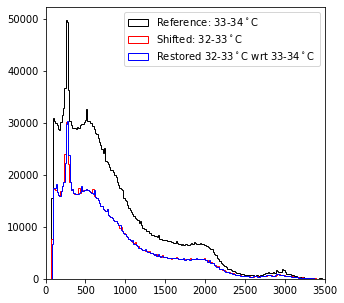

In [452]:
plt.rcParams['figure.figsize'] = [5,5]

plt.hist(ref_ADC,histtype='step',color='k',bins=500,label="Reference: {}-{}$^\circ$C".format(int(ref_temp),int(ref_temp)+temp_bin_width))
plt.hist(shifted_ADC,histtype='step',color='r',bins=500,label="Shifted: {}-{}$^\circ$C".format(int(shifted_temp),int(shifted_temp)+temp_bin_width))
plt.hist(restored_ADC,bins=500,histtype='step',color='b',
    label="Restored {}-{}$^\circ$C wrt {}-{}$^\circ$C".format(int(shifted_temp),int(shifted_temp)+temp_bin_width,int(ref_temp),int(ref_temp)+temp_bin_width))
plt.xlim(0,3500)
plt.legend(loc='best')